In [1]:
import os
import zipfile
import modin.pandas as md
import pandas as pd
import numpy as np
import QuantLib as ql
from scipy import interpolate
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from datetime import timedelta
from model_settings import ms
notebook_dir = str(Path().resolve())
data_dir = os.path.join(str(Path().resolve().parent.parent.parent),'cboe_data')
orders_dir = os.path.join(data_dir,'cboe_zips')
orders = os.listdir(orders_dir)
for i,o in enumerate(orders):
    print(f"{i}     {o}")


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

0     order_000064711


In [2]:
order_dir = os.path.join(orders_dir,orders[0])
order = os.listdir(order_dir)[0]
order

'item_000074207'

# extract zips

# compile dataset

In [3]:
extractions = [f for f in os.listdir(data_dir) if f.find('zip')==-1]
for i,e in enumerate(extractions):
    print(f"{i}     {e}")

0     2024-10-16 15-27-07 extraction


In [4]:
try:
    store = extractions[0]
    print(f"\n{store}")
    contracts_dir = os.path.join(data_dir,store)
    files = os.listdir(contracts_dir)
    files = [f for f in files if f.startswith('UnderlyingOptionsTradesCalcs')]
except Exception:
    print("possible invalid file index")


2024-10-16 15-27-07 extraction


In [5]:
files = files[:10]

In [6]:
dfs = []
bar = tqdm(total = len(files))
for file in files:
    dfs.append(pd.read_csv(os.path.join(contracts_dir,file)))
    bar.update(1)
df = pd.concat(dfs,ignore_index=True)
bar.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.10it/s]


In [7]:
spot_name = 'underlying_bid'

df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
df['expiration'] = pd.to_datetime(df['expiration'])
df['days_to_maturity'] = (df['expiration'] - df['quote_datetime']).dt.days
df['option_type'] = df['option_type'].map({'C': 'call', 'P': 'put'})

df['strike'] = df['strike'].replace(0,np.nan)
df[spot_name] = df[spot_name].replace(0,np.nan)
df['trade_iv'] = df['trade_iv'].replace(0,np.nan)
df.dropna(subset=['strike',spot_name,'trade_iv'])

df['datetime'] = df['quote_datetime'].dt.floor('D')
dates = df['datetime'].unique()

dfby_date = df.groupby('datetime')

In [50]:
# surfaces = {}

# for date in dates[:1]:
date = dates[0]

r = 0.04
g = 0.0

calculation_date = ql.Date(date.day,date.month,date.year)
printdate = str(date.strftime('%A, ')+str(calculation_date))

today =  dfby_date.get_group(date).dropna(subset = ['trade_iv','strike','days_to_maturity','underlying_ask'])
today = today.sort_values(by='quote_datetime',ascending=False)
today.columns
spots = today['underlying_ask'].unique()


todayby_s = today.groupby('underlying_ask')

subsets = {}


for spot in spots:
    subset = todayby_s.get_group(spot)
    nK = len(subset['strike'])
    subsets[nK] = subset

today = subsets[max(subsets.keys())].copy()
s = today['underlying_ask'].iloc[0]
today.loc[:,'moneyness'] = ms.vmoneyness(today['underlying_ask'],today['strike'],today['option_type'])
today = today[today['moneyness']<0]
today = today[
    (today['strike']>=0.9*s)
    &
    (today['strike']<=1.1*s)
][['strike','option_type','trade_price','underlying_ask','days_to_maturity','trade_iv','quote_datetime']].drop_duplicates().reset_index(drop=True).copy()
today['skt'] = today['underlying_ask'].astype(str) + today['strike'].astype(str) + today['days_to_maturity'].astype(str)
today = today.drop_duplicates(subset=['skt']).reset_index()
print(today.shape[0])
pd.set_option("display.max_rows",None)
today.sort_values(by=['strike'])

57


,index,strike,option_type,trade_price,underlying_ask,days_to_maturity,trade_iv,quote_datetime,skt
44,138,1150.0,put,0.10,1277.06,2,0.4531,2012-01-03 16:08:25.404,1277.061150.02
32,86,1150.0,put,1.30,1277.06,17,0.2842,2012-01-03 16:12:09.266,1277.061150.017
27,67,1170.0,put,11.40,1277.06,45,0.2681,2012-01-03 16:12:57.876,1277.061170.045
48,146,1175.0,put,2.30,1277.06,17,0.2666,2012-01-03 16:07:19.214,1277.061175.017
50,159,1185.0,put,0.15,1277.06,2,0.3594,2012-01-03 16:06:54.491,1277.061185.02
29,77,1185.0,put,3.00,1277.06,17,0.2617,2012-01-03 16:12:20.068,1277.061185.017
39,123,1190.0,put,3.20,1277.06,17,0.2549,2012-01-03 16:09:23.746,1277.061190.017
37,116,1195.0,put,3.60,1277.06,17,0.2520,2012-01-03 16:09:45.287,1277.061195.017
6,12,1200.0,put,4.30,1277.06,17,0.2534,2012-01-03 16:14:57.027,1277.061200.017
7,14,1200.0,put,0.20,1277.06,2,0.3164,2012-01-03 16:14:56.355,1277.061200.02


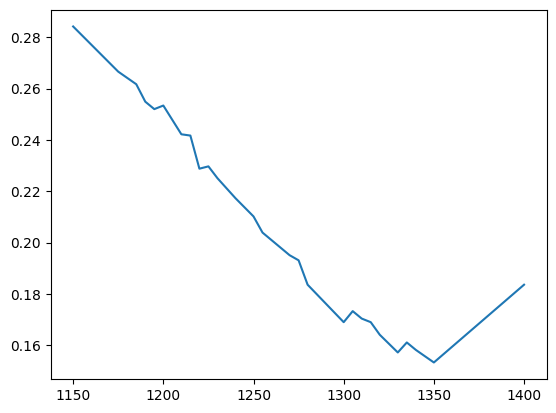

In [55]:
import matplotlib.pyplot as plt
plt.plot(today[today['days_to_maturity']==17].sort_values(by='strike').set_index('strike')['trade_iv'])

In [51]:
ql.Settings.instance().evaluationDate = calculation_date
flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

    
for i,row in today.iterrows():
    t = row['days_to_maturity']
    k = row['strike']
    volatility = row['trade_iv']
    
    p = ql.Period(int(t),ql.Days)
    helper = ql.HestonModelHelper(
        p, ms.calendar, float(s), k, 
        ql.QuoteHandle(ql.SimpleQuote(volatility)), 
        flat_ts, 
        dividend_ts
        )
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)


lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)

model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = pd.Series(
    [theta, kappa, eta, rho, v0],
    index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
    dtype = float
)

print(f"\n{printdate}\n{heston_parameters}")

calibration_test_data = today.copy()[['strike','option_type','trade_price','trade_iv','days_to_maturity']]
calibration_test_data.columns = ['strike_price','w','market_price','volatility','days_to_maturity']
calibration_test_data['spot_price'] = s
calibration_test_data['risk_free_rate'] = r
calibration_test_data['dividend_rate'] = g
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
    calibration_test_data['spot_price'].values,
    calibration_test_data['strike_price'].values,
    calibration_test_data['w'].values)
calibration_test_data['calculation_date'] = date
calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values/calibration_test_data['black_scholes'].values - 1
avg = np.mean(np.abs(calibration_test_data['error']))
print(f"average absolute error: {round(avg*100,5)}%")


Tuesday, January 3rd, 2012
theta     0.045944
kappa    82.260076
eta       6.741257
rho      -0.346375
v0        0.017564
dtype: float64
average absolute error: 23.58651%
